# Hawkes fit to start times
Load the imports:

In [17]:
from preprocessing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

We will use the following kernel:
$$
\mu_i(t) = \alpha_i e^{-\beta_i t},\, 0 \leq \alpha_i \leq \beta_i
$$

In [2]:
def hawkes_log_likelihood(t, alpha, beta, lambda_p): 
    ratio = alpha/beta
    A = []
    for i in range(0, len(t)):
        if i==0:
            A.append(0)
        else:
            A.append(np.exp(-1*beta*(t[i] - t[i-1]))*(1+A[i-1]))
    A = np.array(A)
    first_sum = np.sum(np.log(lambda_p + alpha*A))
    tk = t[-1]
    second_sum = ratio * np.sum(np.exp(-beta*(tk - t)) - 1)
    ret = first_sum + second_sum - lambda_p*tk
    return ret

#hawkes_log_likelihood(train_sorted_stations_start[0].start_time.to_numpy(),1,1,1)


In [86]:
class OptimizationError(RuntimeError):
    pass

optimal_parameters = {}
for station in train_sorted_stations_start:
    print(station.start_id.to_numpy()[0])
    x0 = [np.log(0.1), np.log(1), np.log(0.1)] # np.log(rates_dict[station.start_id.unique()[0]])]
    op_hawkes_likelihood = lambda x: -hawkes_log_likelihood(station.start_time.to_numpy(), np.exp(x[0]), np.exp(x[0]) + np.exp(x[1]), np.exp(x[2]))
    sol = op.minimize(op_hawkes_likelihood, x0, method="Nelder-Mead")
    if sol.success:
        transformed_alpha = np.exp(sol.x[0])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[0])
        transformed_lambda = np.exp(sol.x[2])
        max_params = [transformed_alpha, transformed_beta, transformed_lambda]
        optimal_parameters[station.start_id.unique()[0]] = max_params
        
    else:
        raise OptimizationError("Failed to converge.")
optimal_parameters

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
60
61
62
63
64
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
199
200
201
202
203
204
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
286
287


{1: [0.014105584211228333, 0.02301814450394308, 0.005462485599069215],
 2: [0.021211544692713784, 0.023020779569464144, 0.003801893930019313],
 3: [0.019415470445194448, 0.027978887440940556, 0.004185151013843701],
 4: [0.22669273306146007, 0.9426895405988711, 0.012929901943356378],
 5: [0.022903265383339314, 0.02607711223270739, 0.006238756738192807],
 6: [0.019877238881675183, 0.024379850369854923, 0.00629661773480605],
 7: [0.1298994244658351, 0.4226991680699751, 0.017105426548504995],
 8: [0.022882142328128432, 0.02666658736342031, 0.008523919328312585],
 9: [0.35793860230789243, 0.9825980665528677, 0.016191437721057397],
 10: [0.29115988257109476, 0.7717231625863517, 0.015048368000132279],
 11: [0.014346239828370392, 0.017854195709840703, 0.004654999222190903],
 12: [0.014734645520913185, 0.01812535923594873, 0.00428844415761166],
 13: [0.1535675422068299, 0.7521819653595835, 0.013208583857626863],
 14: [0.032985708917022884, 0.03866235216609299, 0.011579779697698961],
 15: [0.134

Compute the compensator $\Lambda(t)$ using the formula found in Laub 15

In [3]:
def goodcompensator(t, alpha, beta, lambda_p):
    t = np.array(t)
    result = [lambda_p*t[0]]
    ratio = alpha/beta
    for k in range(1,len(t)):
            result.append(lambda_p*t[k]-ratio * np.sum(np.exp(-beta * (t[k]-t[:k])) - 1))
    return result

Compute the compensator $\Lambda_j(t_i)$ for each station $j$ and each event time $t_i$

In [108]:
param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "lambda"])
param_df.head()
param_df.to_csv("../data/N_M_params.csv")

In [4]:
# hawkes_parameters = pd.read_csv('../data/hawkes_parameters.csv', index_col=0)
# hawkes_parameters = param_df
hawkes_parameters = pd.read_csv("../data/N_M_params.csv", index_col=0)
hawkes_parameters

,alpha,beta,lambda
1,0.014106,0.023018,0.005462
2,0.021212,0.023021,0.003802
3,0.019415,0.027979,0.004185
4,0.226693,0.942690,0.012930
5,0.022903,0.026077,0.006239
...,...,...,...
836,0.015292,0.022648,0.008637
838,0.017671,0.026426,0.004331
839,0.253133,0.770489,0.028866
840,0.015301,0.015356,0.000055


In [5]:
compensated_times_dict = {}
for i in range(len(hawkes_parameters.index.to_numpy())):
    params = hawkes_parameters.to_numpy()[i]
    time = train_sorted_stations_start[i].start_time.to_numpy()
    compensated_times_dict[station_array[i]] = goodcompensator(time, params[0], params[1], params[2])

In [6]:
hawkes_p_values = {}

for station_id in compensated_times_dict.keys():
    rate = rates_dict[station_id]
    inter_arrival_times = np.diff(compensated_times_dict[station_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict[station_id][0]) #change first inter-arrival time to t_1
    station_p_values = np.exp(-inter_arrival_times)
    hawkes_p_values[station_id] = station_p_values

hawkes_p_values[1]

array([0.09800189, 0.40685402, 0.33529372, ..., 0.74843495, 0.39201946,
       0.27569296])

(array([173., 151., 161., 197., 155., 166., 151., 142., 120., 287.]),
 array([4.75647156e-04, 1.00422648e-01, 2.00369649e-01, 3.00316650e-01,
        4.00263651e-01, 5.00210652e-01, 6.00157653e-01, 7.00104653e-01,
        8.00051654e-01, 8.99998655e-01, 9.99945656e-01]),
 <BarContainer object of 10 artists>)

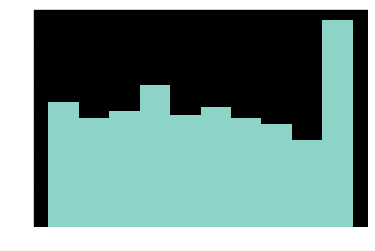

In [7]:
plt.hist(hawkes_p_values[1])

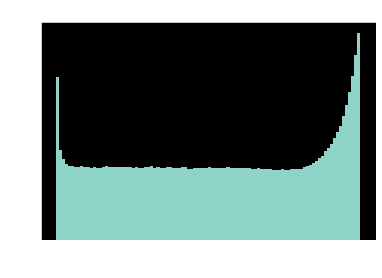

In [8]:
joined_p_values = np.concatenate(np.array(list(hawkes_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m2.png")
plt.show()

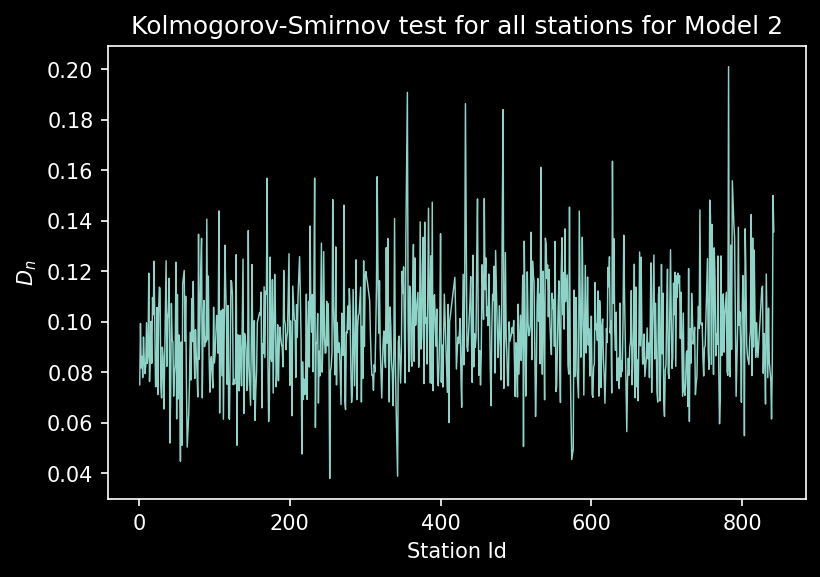

In [27]:
kol_smir_test = {}
for station_id, pvals in hawkes_p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 2")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m2.png")
plt.show()

In [10]:
ks_df = pd.DataFrame(kol_smir_test.values(), index=kol_smir_test.keys(), columns = ["ks"])
ks_df.head()
outlier_ids = ks_df[ks_df.ks > 0.5].index.to_numpy()
print(outlier_ids)
for id in outlier_ids:
    print(optimal_parameters[id])

[]


In [11]:
print(len(train_bike_data[train_bike_data.start_id == 794]))
print(len(train_bike_data[train_bike_data.start_id == 841]))

392
296


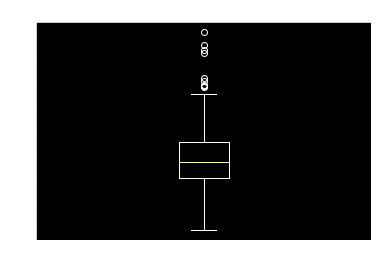

In [12]:
plt.boxplot(kol_smir_test.values())
plt.title("Boxplot of Kolmogorov-Smirnov test statistic for Model 2")
plt.show()

In [13]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

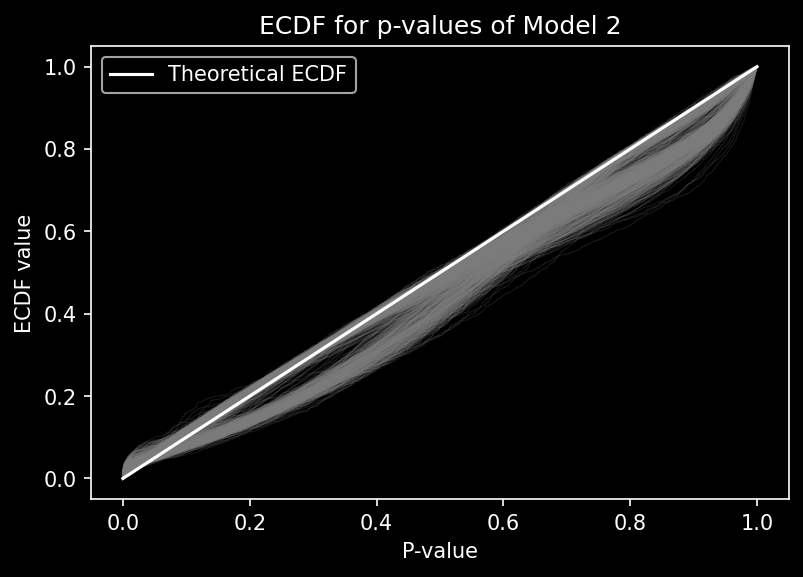

In [36]:
for station, pvals in hawkes_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 2")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()

# Test with test set

In [19]:
compensated_test_times_dict = {}
for i in range(len(hawkes_parameters.index.to_numpy())):
    params = hawkes_parameters.to_numpy()[i]
    time = test_sorted_stations[i].start_time.to_numpy()
    compensated_test_times_dict[station_array[i]] = goodcompensator(time, params[0], params[1], params[2])
#compensated_test_times_dict

In [21]:
hawkes_test_p_values = {}

for station_id in compensated_test_times_dict.keys():
    rate = rates_dict[station_id]
    test_inter_arrival_times = np.diff(compensated_test_times_dict[station_id])
    test_inter_arrival_times = np.insert(test_inter_arrival_times,0,compensated_test_times_dict[station_id][0]) #change first inter-arrival time to t_1
    station_test_p_values = np.exp(-test_inter_arrival_times)
    hawkes_test_p_values[station_id] = station_test_p_values

#hawkes_test_p_values[1]

(array([56., 57., 48., 55., 49., 53., 52., 50., 39., 76.]),
 array([6.57815663e-288, 9.99844073e-002, 1.99968815e-001, 2.99953222e-001,
        3.99937629e-001, 4.99922037e-001, 5.99906444e-001, 6.99890851e-001,
        7.99875258e-001, 8.99859666e-001, 9.99844073e-001]),
 <BarContainer object of 10 artists>)

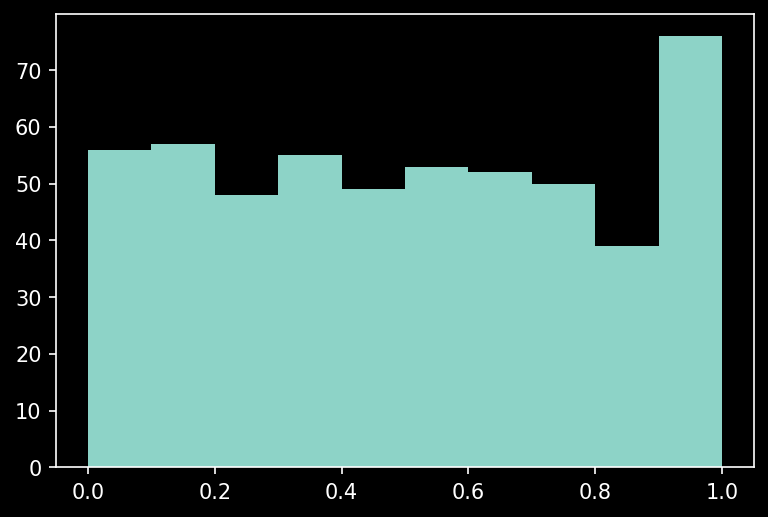

In [23]:
plt.hist(hawkes_test_p_values[1])

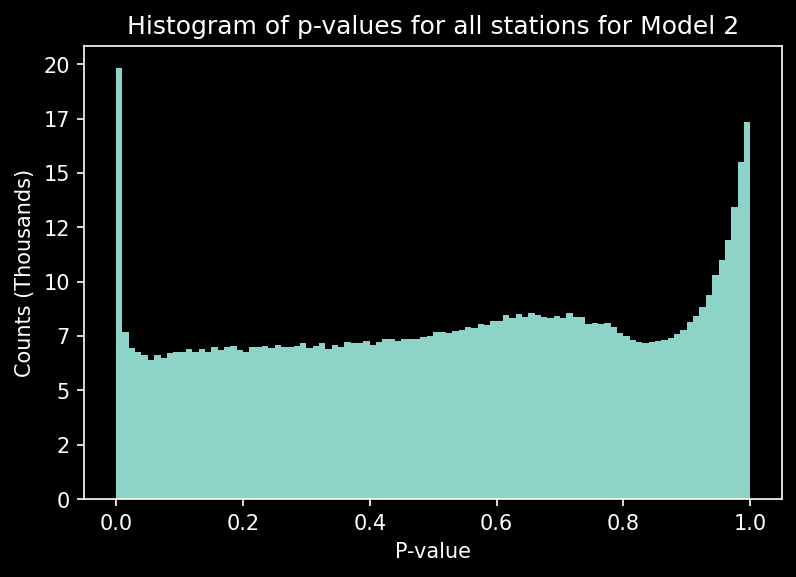

In [24]:
joined_p_values = np.concatenate(np.array(list(hawkes_test_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m2.png")
plt.show()

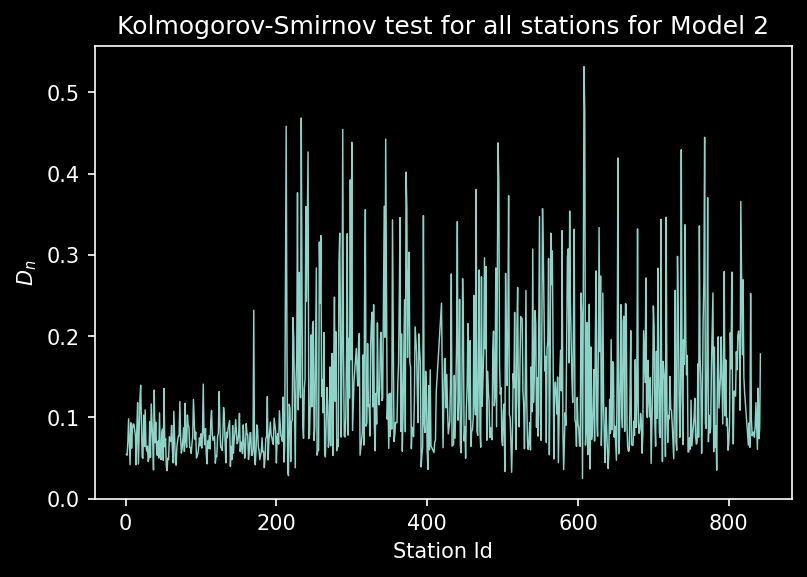

In [28]:
kol_smir_test_test = {}
for station_id, pvals in hawkes_test_p_values.items():
    kol_smir_test_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test_test.keys(), kol_smir_test_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 2")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m2_test.png")
plt.show()

In [ ]:
# ks_test_df = pd.DataFrame(kol_smir_test_test.values(), index=kol_smir_test_test.keys(), columns = ["ks"])
# ks_test_df.head()
# test_outlier_ids = ks_test_df[ks_test_df.ks > 0.5].index.to_numpy()
# print(test_outlier_ids)
# for id in test_outlier_ids:
#     print(optimal_parameters[id])

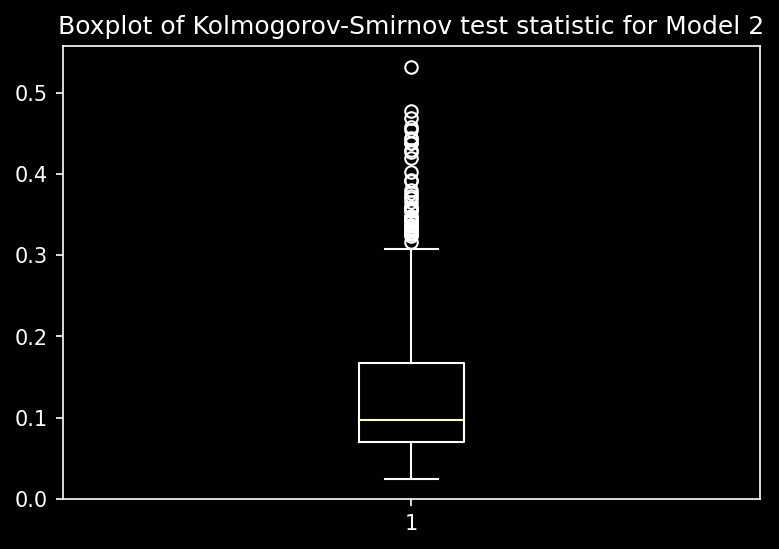

In [29]:
plt.boxplot(kol_smir_test_test.values())
plt.title("Boxplot of KS test statistic for Model 2")
plt.show()

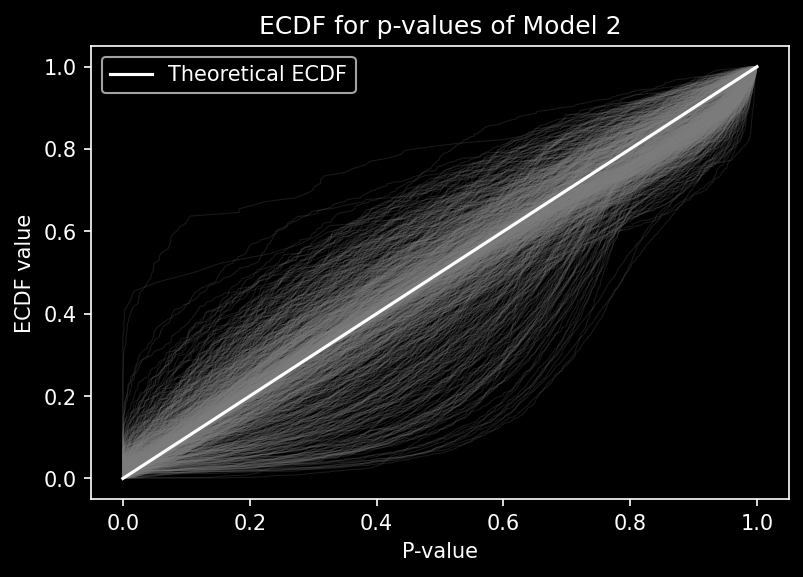

In [34]:
for station, pvals in hawkes_test_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 2")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()